In [ ]:
import torch
import numpy as np
import os
def gauss_sketch_matrix_file(sketch_size: int, d: int,n) -> torch.Tensor:
    for i in range(n):
      sketch = np.random.normal(loc=0.0, scale=1/np.sqrt(d), size=(sketch_size,d))
      filepath=f"/kaggle/working/gauss_matrix_all/gauss_sketch_matrix{i}.pt"
      if not os.path.exists(os.path.dirname(filepath)):
        os.makedirs(os.path.dirname(filepath))
      torch.save(torch.tensor(sketch, dtype=torch.float32), filepath)
    return torch.load(filepath, weights_only=False), print("all sketched matrix saved in file")

In [1]:
import torch
import numpy as np
import os
def gauss_sketch_matrix_file(sketch_size: int, d: int, n: int, s_q_path: str, s_k_path: str) -> torch.Tensor:
    for i in range(n):
        sketch = np.random.normal(loc=0.0, scale=1/np.sqrt(d), size=(sketch_size, d))
        filepath = s_q_path if i == 0 else s_k_path
        if not os.path.exists(os.path.dirname(filepath)):
            os.makedirs(os.path.dirname(filepath))
        torch.save(torch.tensor(sketch, dtype=torch.float32), filepath)
    return torch.load(s_q_path, weights_only=False), print(f"Sketch matrices saved: {s_q_path}, {s_k_path}")

In [ ]:
gauss_sketch_matrix_file(384,768,5)

In [2]:
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=512, patch_size=16, in_ch=3, emb_dim=768):
        super().__init__()
        self.proj = nn.Conv2d(
            in_channels=in_ch,
            out_channels=emb_dim,
            kernel_size=patch_size,
            stride=patch_size
        )
        self.num_patches = (img_size // patch_size) ** 2

    def forward(self, x):
        # x: (B, 3, 32, 32)
        x = self.proj(x)                    # → (B, emb_dim, H', W') = (B, 64, 8, 8)
        x = x.flatten(2)                    # → (B, 64, 64) — flatten H' and W'
        x = x.transpose(1, 2)               # → (B, 64, 64) → (B, num_patches, emb_dim)
        return x


In [3]:
class ViTWithPosition(nn.Module):
    def __init__(self, patch_embed, emb_dim=768, num_patches=1024):
        super().__init__()
        self.patch_embed = patch_embed  # instance of PatchEmbedding
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, emb_dim))  # +1 for CLS

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)                      # (B, 64, 64)
        cls = self.cls_token.expand(B, -1, -1)       # (B, 1, 64)
        x = torch.cat([cls, x], dim=1)               # (B, 65, 64)
        x = x + self.pos_embed                       # add positional encoding
        return x


below one is singel head only

In [4]:
class SketchSelfAttention(nn.Module):
    def __init__(self, dim=768, sketch_dim=256, use_sketch=False,
                 train_mode=False, wq_path=None, wk_path=None,
                 s_q_path=None, s_k_path=None):
        super().__init__()
        self.dim = dim
        self.sketch_dim = sketch_dim
        self.use_sketch = use_sketch
        self.train_mode = train_mode

        self.Wv = nn.Linear(dim, dim)
        self.out_proj = nn.Linear(dim, dim)

        if use_sketch:
            if train_mode:
                assert s_q_path and s_k_path
                self.register_buffer("S_q", torch.tensor(torch.load(s_q_path, weights_only=False), dtype=torch.float32))
                self.register_buffer("S_k", torch.tensor(torch.load(s_k_path, weights_only=False), dtype=torch.float32))
                self.Wq = nn.Linear(dim, dim, bias=False)
                self.Wk = nn.Linear(dim, dim, bias=False)
            else:
                assert wq_path and wk_path
                Wq_sketch = torch.load(wq_path)  # (d, r)
                Wk_sketch = torch.load(wk_path)
                self.Wq = nn.Linear(dim, sketch_dim, bias=False)
                self.Wk = nn.Linear(dim, sketch_dim, bias=False)
                self.Wq.weight.data.copy_(Wq_sketch.T)
                self.Wk.weight.data.copy_(Wk_sketch.T)
        else:
            self.Wq = nn.Linear(dim, dim)
            self.Wk = nn.Linear(dim, dim)
    def forward(self, x):
        if self.use_sketch and self.train_mode:
            Wq_sketched = self.Wq.weight @ self.S_q.T  # (d, r)
            Wk_sketched = self.Wk.weight @ self.S_k.T

            q = x @ Wq_sketched  # (B, N, r)
            k = x @ Wk_sketched  # (B, N, r)
        else:
            q = self.Wq(x)
            k = self.Wk(x)

        v = self.Wv(x)
        scale = q.shape[-1] ** -0.5
        attn = torch.softmax(q @ k.transpose(-2, -1) * scale, dim=-1)
        out = attn @ v
        return self.out_proj(out)


below one is all rounder

In [5]:
class SketchSelfAttention(nn.Module):
    def __init__(self, dim=768, sketch_dim=256, num_heads=1, layer_idx=0,
                 use_sketch=False, train_mode=False,
                 wq_dir=None, wk_dir=None, s_q_path=None, s_k_path=None):
        super().__init__()
        self.dim = dim
        self.sketch_dim = sketch_dim
        self.num_heads = num_heads
        self.layer_idx = layer_idx
        self.train_mode = train_mode
        self.use_sketch = use_sketch

        self.head_dim = dim if num_heads == 1 else dim // num_heads
        self.sketch_head_dim = sketch_dim if num_heads == 1 else sketch_dim // num_heads
        assert dim % num_heads == 0 and sketch_dim % num_heads == 0

        self.Wv = nn.Linear(dim, dim)
        self.out_proj = nn.Linear(dim, dim)

        self.Wq_list = nn.ModuleList()
        self.Wk_list = nn.ModuleList()
        self.S_q_list = []
        self.S_k_list = []

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        for h in range(num_heads):
            if use_sketch:
                if train_mode:
                    
                    s_q_file = f"{s_q_path}_q.pt" if num_heads == 1 else f"{s_q_path}_head{h}_q.pt"
                    s_k_file = f"{s_k_path}_k.pt" if num_heads == 1 else f"{s_k_path}_head{h}_k.pt"
                    S_q = torch.load(s_q_file, weights_only=False).clone().detach().to(device)
                    S_k = torch.load(s_k_file, weights_only=False).clone().detach().to(device)
                    self.S_q_list.append(S_q)
                    self.S_k_list.append(S_k)
                    self.Wq_list.append(nn.Linear(self.head_dim, self.head_dim, bias=False))
                    self.Wk_list.append(nn.Linear(self.head_dim, self.head_dim, bias=False))
                else:
                    assert wq_dir and wk_dir
                    Wq_sketched = torch.load(f"{wq_dir}/Wq_layer{layer_idx}_head{h}.pt")
                    Wk_sketched = torch.load(f"{wk_dir}/Wk_layer{layer_idx}_head{h}.pt")
                    wq = nn.Linear(self.head_dim, self.sketch_head_dim, bias=False)
                    wk = nn.Linear(self.head_dim, self.sketch_head_dim, bias=False)
                    wq.weight.data.copy_(Wq_sketched.T)
                    wk.weight.data.copy_(Wk_sketched.T)
                    self.Wq_list.append(wq)
                    self.Wk_list.append(wk)
            else:
                self.Wq_list.append(nn.Linear(self.head_dim, self.head_dim, bias=False))
                self.Wk_list.append(nn.Linear(self.head_dim, self.head_dim, bias=False))
    def forward(self, x):
        B, N, _ = x.shape
        x = x.view(B, N, self.num_heads, self.head_dim).transpose(1, 2)  # (B, heads, N, head_dim)

        q_all, k_all, v = [], [], self.Wv(x.transpose(1, 2).reshape(B, N, self.dim))

        for h in range(self.num_heads):
            x_h = x[:, h]  # (B, N, head_dim)

            if self.use_sketch and self.train_mode:
                Wq_sk = self.Wq_list[h].weight @ self.S_q_list[h].T
                Wk_sk = self.Wk_list[h].weight @ self.S_k_list[h].T
                q_h = x_h @ Wq_sk
                k_h = x_h @ Wk_sk
            else:
                q_h = self.Wq_list[h](x_h)
                k_h = self.Wk_list[h](x_h)

            q_all.append(q_h)
            k_all.append(k_h)

        q = torch.stack(q_all, dim=1)
        k = torch.stack(k_all, dim=1)

        scale = q.shape[-1] ** -0.5
        attn = torch.softmax(q @ k.transpose(-2, -1) * scale, dim=-1)

        v = x  
        out = attn @ v
        out = out.transpose(1, 2).reshape(B, N, self.dim)
        return self.out_proj(out)


In [6]:
class SimpleTransformerBlock(nn.Module):
    def __init__(self, dim, sketch_dim, num_heads, use_sketch,
                 train_mode, layer_idx,
                 wq_dir=None, wk_dir=None, s_q_path=None, s_k_path=None):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = SketchSelfAttention(dim=dim, sketch_dim=sketch_dim,
                                        num_heads=num_heads,
                                        use_sketch=use_sketch,
                                        train_mode=train_mode,
                                        layer_idx=layer_idx,
                                        wq_dir=wq_dir, wk_dir=wk_dir,
                                        s_q_path=s_q_path, s_k_path=s_k_path)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.GELU(),
            nn.Linear(dim * 2, dim)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


In [7]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=512, patch_size=16, in_ch=3, emb_dim=768, depth=1, num_heads=1,
                 sketch_dim=256, num_classes=40, use_sketch=True, train_mode=True,
                 wq_dir=None, wk_dir=None, s_q_path=None, s_k_path=None):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_ch, emb_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, emb_dim))

        self.blocks = nn.Sequential(*[
            SimpleTransformerBlock(emb_dim, sketch_dim, num_heads, use_sketch, train_mode, layer_idx=l,
                                  wq_dir=wq_dir, wk_dir=wk_dir,
                                  s_q_path=s_q_path, s_k_path=s_k_path)
            for l in range(depth)
        ])

        self.norm = nn.LayerNorm(emb_dim)
        self.head = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)
        x = x + self.pos_embed
        x = self.blocks(x)
        x = self.norm(x[:, 0])
        return self.head(x)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import time
from tqdm import tqdm
from torchvision.datasets import OxfordIIITPet # Import OxfordIIITPet


transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])
class OxfordIIITPetAdjusted(OxfordIIITPet):
    def __getitem__(self, idx):
        image, label = super().__getitem__(idx)
        return image, label  # Subtract 1 to make labels 0-indexed

train_dataset = OxfordIIITPetAdjusted(root=".", split="trainval", transform=transform, download=True) # Using adjusted dataset
test_dataset = OxfordIIITPetAdjusted(root=".", split="test", transform=transform, download=True)     # Using adjusted dataset

In [ ]:
import shutil
shutil.rmtree("/kaggle/working/oxford-iiit-pet")

In [ ]:
train_size = int(1 * len(train_dataset))
val_size = len(train_dataset) - train_size
trainset, valset = random_split(train_dataset, [train_size, val_size])

In [ ]:
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
val_loader = DataLoader(valset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
print("xyz")

In [1]:
# import os
# from collections import defaultdict, Counter
# import numpy as np
# from PIL import Image
# from torchvision import datasets, transforms
# from torch.utils.data import Dataset, DataLoader
# import torch

# class PlantVillageBalancedDataset(Dataset):
#     def __init__(self, root, selected_classes=None, transform=None, split="train"):
#         self.root = root
#         self.transform = transform
#         self.split = split

#         self.base_dataset = datasets.ImageFolder(root)
#         self.classes = self.base_dataset.classes
#         self.class_to_idx = self.base_dataset.class_to_idx

#         if selected_classes is None:
#             class_counts = Counter([self.classes[label] for _, label in self.base_dataset.samples])
#             top_classes = [cls for cls, _ in class_counts.most_common(25)]
#             self.selected_classes = top_classes
#         else:
#             self.selected_classes = selected_classes

#         self.selected_class_to_idx = {cls: i for i, cls in enumerate(self.selected_classes)}
#         self.idx_remap = {self.class_to_idx[cls]: i for i, cls in enumerate(self.selected_classes)}

#         self.image_paths, self.image_to_class = self._build_balanced_dataset()

#     def _build_balanced_dataset(self):
#         class_to_images = defaultdict(list)
#         for img_path, label in self.base_dataset.samples:
#             class_name = self.classes[label]
#             if class_name in self.selected_classes:
#                 class_to_images[class_name].append(img_path)

#         split_sizes = {"train": 500, "val": 100, "test": 50}
#         split_offset = {"val": (-150, -50), "test": (-50,), "train": (None, -150)}

#         image_paths, image_to_class = [], {}
#         for cls in self.selected_classes:
#             imgs = class_to_images[cls]
#             np.random.shuffle(imgs)

#             if self.split == "train":
#                 selected = imgs[:max(0, len(imgs) - 150)][:500]
#             elif self.split == "val":
#                 selected = imgs[-150:-50][:100]
#             else:  # test
#                 selected = imgs[-50:][:50]

#             for path in selected:
#                 image_paths.append(path)
#                 image_to_class[path] = self.class_to_idx[cls]

#         return image_paths, image_to_class

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         img_path = self.image_paths[idx]
#         img = Image.open(img_path).convert("RGB")
#         if self.transform:
#             img = self.transform(img)
#         label = self.idx_remap[self.image_to_class[img_path]]
#         return img, torch.tensor(label)


# transform = transforms.Compose([
#     transforms.Resize((512, 512)),
#     transforms.ToTensor(),
# ])


# root_path = "/kaggle/input/plantvillage-dataset/color"


# train_dataset = PlantVillageBalancedDataset(root=root_path, transform=transform, split="train")
# selected_classes = train_dataset.selected_classes

# val_dataset = PlantVillageBalancedDataset(root=root_path, transform=transform, split="val", selected_classes=selected_classes)
# test_dataset = PlantVillageBalancedDataset(root=root_path, transform=transform, split="test", selected_classes=selected_classes)


# def collate_fn(batch):
#     images = torch.stack([item[0] for item in batch])
#     labels = torch.tensor([item[1] for item in batch])
#     return images, labels

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=collate_fn)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, collate_fn=collate_fn)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, collate_fn=collate_fn)


# img, label = train_dataset[0]
# print(f"Image shape: {img.shape}, Label: {label}")


Image shape: torch.Size([3, 512, 512]), Label: 0


In [10]:
import os
from collections import defaultdict, Counter
import numpy as np
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch

def extract_category(class_name):
    return class_name.split("_")[0]  # e.g., 'apple_blackrot' → 'apple'

class PlantVillageBalancedDataset(Dataset):
    def __init__(self, root, selected_classes=None, transform=None, split="train"):
        self.root = root
        self.transform = transform
        self.split = split

        self.base_dataset = datasets.ImageFolder(root)
        self.classes = self.base_dataset.classes
        self.class_to_idx = self.base_dataset.class_to_idx

        if selected_classes is None:
            
            class_counts = Counter([self.classes[label] for _, label in self.base_dataset.samples])
            # Filter classes with enough images (≥ 650 total)
            eligible_classes = {cls: count for cls, count in class_counts.items() if count >= 650}

            
            category_to_classes = defaultdict(list)
            for cls in eligible_classes:
                category = extract_category(cls)
                category_to_classes[category].append(cls)

            # Only keep categories with ≥ 2 classes
            final_classes = []
            for category, cls_list in category_to_classes.items():
                if len(cls_list) >= 2:
                    final_classes.extend(cls_list)
                if len(final_classes) >= 21:
                    break

            self.selected_classes = final_classes[:21]  # truncate to top 25
            print(f"[INFO] Selected {len(self.selected_classes)} classes from grouped categories.")
        else:
            self.selected_classes = selected_classes

        self.selected_class_to_idx = {cls: i for i, cls in enumerate(self.selected_classes)}
        self.idx_remap = {self.class_to_idx[cls]: i for i, cls in enumerate(self.selected_classes)}

        self.image_paths, self.image_to_class = self._build_balanced_dataset()

    def _build_balanced_dataset(self):
        class_to_images = defaultdict(list)
        for img_path, label in self.base_dataset.samples:
            class_name = self.classes[label]
            if class_name in self.selected_classes:
                class_to_images[class_name].append(img_path)

        image_paths, image_to_class = [], {}
        for cls in self.selected_classes:
            imgs = class_to_images[cls]
            np.random.shuffle(imgs)

            if self.split == "train":
                selected = imgs[:max(0, len(imgs) - 150)][:500]
            elif self.split == "val":
                selected = imgs[-150:-50][:100]
            else:  # test
                selected = imgs[-50:][:50]

            for path in selected:
                image_paths.append(path)
                image_to_class[path] = self.class_to_idx[cls]

        return image_paths, image_to_class

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = self.idx_remap[self.image_to_class[img_path]]
        return img, torch.tensor(label)

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])


root_path = "/kaggle/input/plantvillage-dataset/color"


train_dataset = PlantVillageBalancedDataset(root=root_path, transform=transform, split="train")
selected_classes = train_dataset.selected_classes

val_dataset = PlantVillageBalancedDataset(root=root_path, transform=transform, split="val", selected_classes=selected_classes)
test_dataset = PlantVillageBalancedDataset(root=root_path, transform=transform, split="test", selected_classes=selected_classes)

def collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    labels = torch.tensor([item[1] for item in batch])
    return images, labels

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, collate_fn=collate_fn)

img, label = train_dataset[0]
print(f"Image shape: {img.shape}, Label: {label}")


[INFO] Selected 21 classes from grouped categories.
Image shape: torch.Size([3, 512, 512]), Label: 0


In [11]:
def verify_class_distribution(dataset, class_names):
    class_counts = torch.zeros(len(class_names))
    
    for _, label in DataLoader(dataset, batch_size=256, collate_fn=collate_fn):
        unique, counts = torch.unique(label, return_counts=True)
        class_counts[unique] += counts.float()
    
    print("\nClass distribution:")
    for i, (name, count) in enumerate(zip(class_names, class_counts)):
        print(f"{i:2d} {name:15s}: {int(count)} samples")

print("=== Training Set ===")
verify_class_distribution(train_dataset, selected_classes)
print("\n=== Validation Set ===")
verify_class_distribution(val_dataset, selected_classes)
print("\n=== Test Set ===")
verify_class_distribution(test_dataset, selected_classes)

=== Training Set ===

Class distribution:
 0 Cherry_(including_sour)___Powdery_mildew: 500 samples
 1 Cherry_(including_sour)___healthy: 500 samples
 2 Corn_(maize)___Common_rust_: 500 samples
 3 Corn_(maize)___Northern_Leaf_Blight: 500 samples
 4 Corn_(maize)___healthy: 500 samples
 5 Grape___Black_rot: 500 samples
 6 Grape___Esca_(Black_Measles): 500 samples
 7 Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 500 samples
 8 Pepper,_bell___Bacterial_spot: 500 samples
 9 Pepper,_bell___healthy: 500 samples
10 Potato___Early_blight: 500 samples
11 Potato___Late_blight: 500 samples
12 Tomato___Bacterial_spot: 500 samples
13 Tomato___Early_blight: 500 samples
14 Tomato___Late_blight: 500 samples
15 Tomato___Leaf_Mold: 500 samples
16 Tomato___Septoria_leaf_spot: 500 samples
17 Tomato___Spider_mites Two-spotted_spider_mite: 500 samples
18 Tomato___Target_Spot: 500 samples
19 Tomato___Tomato_Yellow_Leaf_Curl_Virus: 500 samples
20 Tomato___healthy: 500 samples

=== Validation Set ===

Class distri

In [ ]:
labels = [label for _, label in train_dataset]
print("Min label:", min(labels))  
print("Max label:", max(labels))  

In [ ]:
print("Inspecting labels directly from the train_dataset:")
labels_list = [label for _, label in train_dataset]

print(f"Number of labels inspected: {len(labels_list)}")
print(f"Minimum label value: {min(labels_list)}")
print(f"Maximum label value: {max(labels_list)}")
print(f"Number of unique labels: {len(set(labels_list))}")
print(f"Unique label values: {sorted(list(set(labels_list)))}")

In [12]:
import torch
images, labels = next(iter(train_loader))
print("Image batch shape:", images.shape)
print("Image batch dtype:", images.dtype)
print("Image batch min value:", torch.min(images))
print("Image batch max value:", torch.max(images))
print("\nLabel batch shape:", labels.shape)
print("Label batch dtype:", labels.dtype)
print("Label batch min value:", torch.min(labels))
print("Label batch max value:", torch.max(labels))
print("Number of unique labels in the batch:", len(torch.unique(labels)))

Image batch shape: torch.Size([32, 3, 512, 512])
Image batch dtype: torch.float32
Image batch min value: tensor(0.)
Image batch max value: tensor(1.)

Label batch shape: torch.Size([32])
Label batch dtype: torch.int64
Label batch min value: tensor(1)
Label batch max value: tensor(19)
Number of unique labels in the batch: 17


In [ ]:
# def precompute_and_save_sketch_weights(Wq, Wk, S_q_path, S_k_path, out_dir):
#     S_q = torch.tensor(torch.load(S_q_path, weights_only=False), dtype=Wq.dtype, device=Wq.device)
#     S_k = torch.tensor(torch.load(S_k_path, weights_only=False), dtype=Wk.dtype, device=Wk.device)
#     Wq_sketched = Wq @ S_q.T
#     Wk_sketched = Wk @ S_k.T
#     torch.save(Wq_sketched, f"{out_dir}/Wq_sketched.pt")
#     torch.save(Wk_sketched, f"{out_dir}/Wk_sketched.pt")
#     print("Sketched weights saved.")

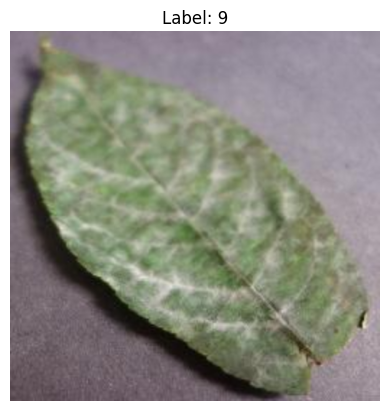

In [21]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

images, labels = next(iter(train_loader))

img_tensor = images[12]
label = labels[0].item()

img_pil = F.to_pil_image(img_tensor)
plt.imshow(img_pil)
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()


In [ ]:
class_name = selected_classes[]
plt.title(f"Label: {label} ({class_name})")

In [13]:
def train_model(model, optimizer, criterion, dataloader, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        correct, total = 0, 0
        loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for x, y in loop:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
            loop.set_postfix(loss=loss.item(), acc=correct/total)
    return correct / total

def evaluate(model, dataloader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total

def time_inference(model, dataloader, device, repetitions=30):
    model.eval()
    start = time.time()
    with torch.no_grad():
        for i, (x, _) in enumerate(dataloader):
            if i >= repetitions: break
            x = x.to(device)
            _ = model(x)
    end = time.time()
    return (end - start) * 1000  # ms



In [14]:
def save_sketched_weights_per_head(model, s_q_path, s_k_path, save_dir_q, save_dir_k):
    os.makedirs(save_dir_q, exist_ok=True)
    os.makedirs(save_dir_k, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    depth = len(model.blocks)
    for l in range(depth):
        attn = model.blocks[l].attn
        for h in range(attn.num_heads):
            Wq = attn.Wq_list[h].weight.data
            Wk = attn.Wk_list[h].weight.data

            s_q_file = f"{s_q_path}_q.pt" if attn.num_heads == 1 else f"{s_q_path}_head{h}_q.pt"
            s_k_file = f"{s_k_path}_k.pt" if attn.num_heads == 1 else f"{s_k_path}_head{h}_k.pt"
            Sq_h = torch.load(s_q_file, weights_only=False).clone().detach().to(device)
            Sk_h = torch.load(s_k_file, weights_only=False).clone().detach().to(device)

            Wq_sk = Wq @ Sq_h.T
            Wk_sk = Wk @ Sk_h.T

            torch.save(Wq_sk, f"{save_dir_q}/Wq_layer{l}_head{h}.pt")
            torch.save(Wk_sk, f"{save_dir_k}/Wk_layer{l}_head{h}.pt")

In [25]:
from tqdm import tqdm
# EXPERIMENT
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_s_q_path = "/kaggle/working/gauss_matrix_all/gauss_sketch_matrix"
base_s_k_path = "/kaggle/working/gauss_matrix_all/gauss_sketch_matrix"
WQ_SAVE_DIR = "/kaggle/working/sketched_weights_q"
WK_SAVE_DIR = "/kaggle/working/sketched_weights_k"

depth = 4
num_heads = 1   
sketch_dim = 256
dim = 768


head_dim = dim if num_heads == 1 else dim // num_heads  # 768 (single-head) or 192 (multi-head)
sketch_head_dim = sketch_dim if num_heads == 1 else sketch_dim // num_heads  # 384 or 96


if num_heads == 1:
    gauss_sketch_matrix_file(sketch_head_dim, head_dim, 2,
                             f"{base_s_q_path}_q.pt",
                             f"{base_s_k_path}_k.pt")
else:
    for h in range(num_heads):
        gauss_sketch_matrix_file(sketch_head_dim, head_dim, 2,
                                 f"{base_s_q_path}_head{h}_q.pt",
                                 f"{base_s_k_path}_head{h}_k.pt")
# criterion = nn.CrossEntropyLoss()

import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
# Normal ViT
normal_model = VisionTransformer(depth=depth, num_heads=num_heads,
                                 use_sketch=False).to(device)
optimizer = torch.optim.Adam(normal_model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
print("Training Normal ViT")
acc_train_normal = train_model(normal_model, optimizer, criterion, train_loader, device, epochs=10)
acc_val_normal = evaluate(normal_model, val_loader, device)  
acc_test_normal = evaluate(normal_model, test_loader, device)

Sketch matrices saved: /kaggle/working/gauss_matrix_all/gauss_sketch_matrix_q.pt, /kaggle/working/gauss_matrix_all/gauss_sketch_matrix_k.pt
Training Normal ViT


Epoch 1/10:   1%|          | 3/329 [00:07<14:03,  2.59s/it, acc=0.0104, loss=3.8] 


KeyboardInterrupt: 

In [16]:
import time
inf_time_normal = time_inference(normal_model, test_loader, device)

In [17]:
print("Training Sketched ViT")
sketch_model = VisionTransformer(depth=depth, num_heads=num_heads,
                                 sketch_dim=sketch_dim,
                                 use_sketch=True, train_mode=True,
                                 s_q_path=base_s_q_path, s_k_path=base_s_k_path).to(device)
optimizer_sketch = torch.optim.Adam(sketch_model.parameters(), lr=0.0001)

acc_train_sketch = train_model(sketch_model, optimizer_sketch, criterion, train_loader, device, epochs=10)
acc_val_sketch = evaluate(sketch_model, val_loader, device)  
acc_test_sketch = evaluate(sketch_model, test_loader, device)



from pathlib import Path
Path(WQ_SAVE_DIR).mkdir(parents=True, exist_ok=True)
Path(WK_SAVE_DIR).mkdir(parents=True, exist_ok=True)

save_sketched_weights_per_head(sketch_model, base_s_q_path, base_s_k_path, WQ_SAVE_DIR, WK_SAVE_DIR)

# Sketched ViT: INFERENCE ONLY
sketched_infer_model = VisionTransformer(depth=depth, num_heads=num_heads,
                                         sketch_dim=sketch_dim,
                                         use_sketch=True, train_mode=False,
                                         wq_dir=WQ_SAVE_DIR, wk_dir=WK_SAVE_DIR).to(device)
inf_time_sketch = time_inference(sketched_infer_model, test_loader, device)

print("\nFINAL RESULTS")
print(f"Normal ViT     → Train Acc: {acc_train_normal:.4f}, Test Acc: {acc_test_normal:.4f}, Inf Time: {inf_time_normal:.2f} ms")
print(f"Sketched ViT   → Train Acc: {acc_train_sketch:.4f}, Test Acc: {acc_test_sketch:.4f}, Inf Time: {inf_time_sketch:.2f} ms")

Training Sketched ViT


Epoch 10/10: 100%|██████████| 329/329 [02:12<00:00,  2.49it/s, acc=0.868, loss=0.591]



FINAL RESULTS
Normal ViT     → Train Acc: 0.8787, Test Acc: 0.8390, Inf Time: 7037.99 ms
Sketched ViT   → Train Acc: 0.8676, Test Acc: 0.8267, Inf Time: 6975.80 ms


In [18]:
inf_time_normal_val = time_inference(normal_model, val_loader, device)
inf_time_sketch_val = time_inference(sketched_infer_model, val_loader, device)

print(f"Normal val ViT     → val Acc: {acc_val_normal :.4f}, Inf Time val: {inf_time_normal_val:.2f} ms")
print(f"sketched val  ViT     → val Acc: {acc_val_sketch:.4f}, Inf Time val: {inf_time_sketch_val:.2f} ms")

Normal val ViT     → val Acc: 0.8543, Inf Time val: 6966.50 ms
sketched val  ViT     → val Acc: 0.8410, Inf Time val: 6799.19 ms


In [26]:
import shutil
shutil.rmtree("/kaggle/working/sketched_weights_k")
shutil.rmtree("/kaggle/working/sketched_weights_q")
shutil.rmtree("/kaggle/working/gauss_matrix_all")

In [27]:
import os
os.remove("/kaggle/working/sketched_weights_k.zip")
os.remove("/kaggle/working/sketched_weights_q.zip")
os.remove("/kaggle/working/normal_model_trained.pth")
os.remove("/kaggle/working/sim.pth")
os.remove("/kaggle/working/sketch_model_trained.pth")

In [ ]:
# # experiment
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Normal ViT
# normal_model = VisionTransformer(use_sketch=False).to(device)
# optimizer = torch.optim.Adam(normal_model.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()
# #Sketched ViT(train with sketching, test with fused weights)
# S_q_path = "/kaggle/working/gauss_matrix_all/gauss_sketch_matrix1.pt"
# S_k_path = "/kaggle/working/gauss_matrix_all/gauss_sketch_matrix0.pt"

# sketch_model = VisionTransformer(use_sketch=True, train_mode=True,s_q_path=S_q_path, s_k_path=S_k_path).to(device)
# optimizer_sketch = torch.optim.Adam(sketch_model.parameters(), lr=0.001)

# print(" Training Sketched ViT")
# acc_train_sketch = train_model(sketch_model, optimizer_sketch, criterion, train_loader, device, epochs=1)
# acc_test_sketch = evaluate(sketch_model, test_loader, device)


# Wq = sketch_model.blocks[0].attn.Wq.weight.data
# Wk = sketch_model.blocks[0].attn.Wk.weight.data
# precompute_and_save_sketch_weights(Wq, Wk, S_q_path, S_k_path, "/kaggle/working")
# print("Training Normal ViT")
# acc_train_normal = train_model(normal_model, optimizer, criterion, train_loader, device, epochs=1)
# acc_test_normal = evaluate(normal_model, test_loader, device)
# inf_time_normal = time_inference(normal_model, test_loader, device)


# sketched_infer_model = VisionTransformer(use_sketch=True, train_mode=False,wq_path="/kaggle/working/Wq_sketched.pt",wk_path="/kaggle/working/Wk_sketched.pt").to(device)
# inf_time_sketch = time_inference(sketched_infer_model, test_loader, device)

# print("\n FINAL RESULTS")
# print(f"Normal ViT     → Train Acc: {acc_train_normal:.4f}, Test Acc: {acc_test_normal:.4f}, Inf Time: {inf_time_normal:.2f} ms")
# print(f"Sketched ViT   → Train Acc: {acc_train_sketch:.4f}, Test Acc: {acc_test_sketch:.4f}, Inf Time: {inf_time_sketch:.2f} ms")

In [ ]:
import torch
torch.cuda.empty_cache()

In [22]:
model_save_path_sketch = "/kaggle/working/sketch_model_trained.pth"
model_save_path = "/kaggle/working/normal_model_trained.pth"

torch.save(sketch_model.state_dict(), model_save_path_sketch)
torch.save(normal_model.state_dict(), model_save_path)

In [ ]:
# def time_inference(model, dataloader, device, repetitions=30):
#     model.eval()
#     start = time.time()
#     with torch.no_grad():
#       for i in range(1):
#         for i, (x, _) in enumerate(dataloader):
#             if i >= repetitions: break
#             x = x.to(device)
#             _ = model(x)
#     end = time.time()
#     return (end - start) * 1000  # ms
# inf_time_normal = time_inference(normal_model, test_loader, device)



# # Inference with fused sketched weights
# sketched_infer_model = VisionTransformer(use_sketch=True, train_mode=False,
#                                          wq_path="/kaggle/working/Wq_sketched.pt",
#                                          wk_path="/kaggle/working/Wk_sketched.pt").to(device)
# inf_time_sketch = time_inference(sketched_infer_model, test_loader, device)
# print("\n FINAL RESULTS")
# print(f"Normal ViT     → Train Acc: {acc_train_normal:.4f}, Test Acc: {acc_test_normal:.4f}, Inf Time: {inf_time_normal:.2f} ms")
# print(f"Sketched ViT   → Train Acc: {acc_train_sketch:.4f}, Test Acc: {acc_test_sketch:.4f}, Inf Time: {inf_time_sketch:.2f} ms")

In [19]:
import time
import numpy as np
import torch

def time_inference(model, dataloader, device, repetitions=4, verbose=True):
    model.eval()
    timings = []

    if device.type == "cuda":
        torch.cuda.reset_peak_memory_stats(device)

    with torch.no_grad():
        for i, (x, _) in enumerate(dataloader):
            if i >= repetitions:
                break
            x = x.to(device)

            start = time.time()
            _ = model(x)
            torch.cuda.synchronize() if device.type == "cuda" else None
            end = time.time()

            batch_time = (end - start) * 1000  # ms
            timings.append(batch_time)

            if verbose:
                print(f"[Batch {i+1}] Time: {batch_time:.2f} ms")

    avg_time = np.mean(timings) if timings else 0.0
    total_time = np.sum(timings)
    peak_memory_MB = 0.0

    if device.type == "cuda":
        peak_memory_MB = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
        if verbose:
            print(f"[CUDA] Peak memory usage: {peak_memory_MB:.2f} MB")

    if verbose:
        print(f"\n[Inference Summary] Avg Time/Batch: {avg_time:.2f} ms | Total Time: {total_time:.2f} ms")

    return avg_time, peak_memory_MB


In [20]:
inf_time_normal, mem_normal = time_inference(normal_model, test_loader, device)
inf_time_sketch, mem_sketch = time_inference(sketched_infer_model, test_loader, device)

print(f"Normal Model  → Time: {inf_time_normal:.2f} ms | Peak Memory: {mem_normal:.2f} MB")
print(f"Sketched Model → Time: {inf_time_sketch:.2f} ms | Peak Memory: {mem_sketch:.2f} MB")


[Batch 1] Time: 200.89 ms
[Batch 2] Time: 166.08 ms
[Batch 3] Time: 164.20 ms
[Batch 4] Time: 161.54 ms
[CUDA] Peak memory usage: 1982.15 MB

[Inference Summary] Avg Time/Batch: 173.18 ms | Total Time: 692.72 ms
[Batch 1] Time: 145.21 ms
[Batch 2] Time: 143.87 ms
[Batch 3] Time: 145.85 ms
[Batch 4] Time: 147.39 ms
[CUDA] Peak memory usage: 1725.90 MB

[Inference Summary] Avg Time/Batch: 145.58 ms | Total Time: 582.32 ms
Normal Model  → Time: 173.18 ms | Peak Memory: 1982.15 MB
Sketched Model → Time: 145.58 ms | Peak Memory: 1725.90 MB


In [ ]:
# def time_inference(model, dataloader, device, repetitions=30):
#     import os
#     import time
#     import numpy as np
   
#     WQ_DIR = "/kaggle/working/sketched_weights_q"
#     WK_DIR = "/kaggle/working/sketched_weights_k"

#     if hasattr(model, 'blocks') and hasattr(model.blocks[0], 'attn'):
#         attn = model.blocks[0].attn
#         if getattr(attn, 'use_sketch', False) and not getattr(attn, 'train_mode', True):
#             num_heads = getattr(attn, 'num_heads', 1)
#             depth = len(model.blocks)

#             for l in range(depth):
#                 for h in range(num_heads):
#                     wq_path = f"{WQ_DIR}/Wq_layer{l}_head{h}.pt"
#                     wk_path = f"{WK_DIR}/Wk_layer{l}_head{h}.pt"
#                     if not os.path.exists(wq_path):
#                         raise FileNotFoundError(f"Missing {wq_path}")
#                     if not os.path.exists(wk_path):
#                         raise FileNotFoundError(f"Missing {wk_path}")

#    
#     model.eval()
#     timings = []
#     with torch.no_grad():
#         for i, (x, _) in enumerate(dataloader):
#             if i >= repetitions:
#                 break
#             x = x.to(device)
#             torch.cuda.synchronize()
#             start = time.time()
#             _ = model(x)
#             torch.cuda.synchronize()
#             end = time.time()
#             timings.append(end - start)

#     return np.mean(timings) * 1000  # ms


In [21]:
model_path="/kaggle/working/sim.pth"
torch.save(sketched_infer_model.state_dict(),model_path)

In [ ]:
normal_model_load_path = "/kaggle/working/normal_model_trained.pth"
sketched_fused_model_load_path = "/kaggle/working/sim.pth"


In [ ]:
normal_loaded_model = VisionTransformer(use_sketch=False,train_mode=False).to(device)
normal_model_load_path="/kaggle/working/normal_model_trained.pth"
normal_loaded_model.load_state_dict(torch.load(normal_model_load_path, map_location=device))
normal_loaded_model.eval()

In [ ]:
FUSED_WQ_PATH = "/kaggle/working/Wq_sketched.pt"
FUSED_WK_PATH = "/kaggle/working/Wk_sketched.pt"

In [ ]:
sketched_fused_loaded_model= VisionTransformer(use_sketch=True,train_mode=False,wq_path=FUSED_WQ_PATH,wk_path=FUSED_WK_PATH ).to(device)
sketched_fused_model_load_path="/kaggle/working/sim.pth"
sketched_fused_loaded_model.load_state_dict(torch.load(sketched_fused_model_load_path, map_location=device))
sketched_fused_loaded_model.eval()

In [ ]:
normal_accuracy = evaluate(normal_loaded_model, test_loader, device)

In [ ]:
normal_accuracy
normal_inference_time = time_inference(normal_loaded_model, test_loader, device, repetitions=len(test_loader))
normal_inference_time 

In [ ]:
sketched_fused_accuracy = evaluate(sketched_fused_loaded_model, test_loader, device)

In [ ]:
sketched_fused_accuracy

In [ ]:
sketched_fused_inference_time = time_inference(sketched_fused_loaded_model, test_loader, device, repetitions=len(test_loader))

In [ ]:
print(f"Normal ViT - Test Acc: {normal_accuracy:.4f}, Avg. Inference Time/Batch: {normal_inference_time:.2f} ms")
print(f"Sketched ViT (Fused) - Test Acc: {sketched_fused_accuracy:.4f}, Avg. Inference Time/Batch: {sketched_fused_inference_time:.2f} ms")

In [24]:
import shutil
import os

folder_to_zip = '/kaggle/working/sketched_weights_q' 
output_zip = '/kaggle/working/sketched_weights_q.zip'  
shutil.make_archive(output_zip.replace('.zip', ''), 'zip', folder_to_zip)
if os.path.exists(output_zip):
    print(f"Folder zipped successfully as {output_zip}")
else:
    print("Failed to create zip file")

Folder zipped successfully as /kaggle/working/sketched_weights_q.zip
